Circumcenter: [1.5 0.5 2.5]


/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2509: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (col is 'lo') or (col is 'do'):
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2509: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (col is 'lo') or (col is 'do'):
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:3096: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if point_color is 'r':
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:3112: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if point_color is 'r':
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2509: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (col is 'lo') or (col is 'do'):
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2509: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (col is 'lo') or (col is 'do'):
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:3096: Syn

TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

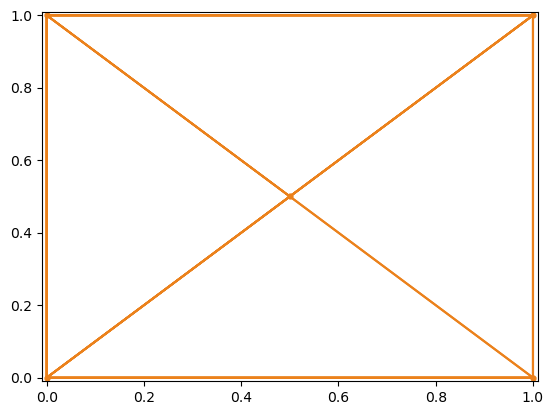

<Figure size 640x480 with 0 Axes>

In [1]:

#import polyscope as ps


# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ddgclib._complex import *
from ddgclib._sphere import *

import numpy as np

def distance(a, b):
    return np.linalg.norm(a - b)

def circumcenter(vertices):
    A, B, C = vertices
    a = distance(B, C)
    b = distance(C, A)
    c = distance(A, B)

    if a == 0 or b == 0 or c == 0:
        raise ValueError("Invalid triangle: degenerate or duplicate vertices")

    # Calculate the circumradius
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    circumradius = (a * b * c) / (4 * area)

    # Calculate the normalized barycentric coordinates
    alpha = (a * a * (b * b + c * c - a * a)) / (a * a + b * b + c * c)
    beta = (b * b * (c * c + a * a - b * b)) / (a * a + b * b + c * c)
    gamma = (c * c * (a * a + b * b - c * c)) / (a * a + b * b + c * c)

    circumcenter = (alpha * A + beta * B + gamma * C) / (alpha + beta + gamma)

    return circumcenter

# Example usage
triangle_vertices = np.array([[1, 2, 0], [4, 0, 1], [0, 0, 5]], dtype=np.float64)
print("Circumcenter:", circumcenter(triangle_vertices))


# Write a function that builds a dual cache called HC.Vd,
# each member of the `Vd` set should be connect only to primal
# vertices in HC.V

#dist = np.linalg.norm(v.x_a - v2.x_a)
#            if dist < cdist:
        
def compute_vd(HC, cdist =1e-10):
    """
    Computes the dual vertices of a primal vertex cache HC.V on
    each dim - 1 simplex.
    
    Currently only dim = 2 is supported
    
    cdist: float, tolerance for where a unique dual vertex can exist
    
    """
    # Construct dual cache
    HC.Vd = VertexCacheField() 
    
    # Construct dual neighbour sets
    for v in HC.V:
        v.vd = set()
            
    #hcv = copy.copy(HC.V)        
    for v1 in HC.V:
        for v2 in v1.nn:
            # Find all v2.nn also connected to v1:
            v1nn_u_v2nn = v1.nn.intersection(v2.nn)
            for v3 in v1nn_u_v2nn:
                # TODO: Re-implement cache:
                verts = np.zeros([3, 2])
                verts[0] = v1.x_a
                verts[1] = v2.x_a
                verts[2] = v3.x_a
                # Compute the circumcentre:
                cd = circumcenter(verts)
                # Note instead of below, could round off cd in general to say nearest 1e-12
                # Check for uniqueness first (new, expensive, could 
                # be improved by checking duals of neighbours only?):
                for vd_i in HC.Vd:
                    dist = np.linalg.norm(vd_i.x_a - cd)
                    if dist < cdist:
                        cd = vd_i.x_a
                        
                vd = HC.Vd[tuple(cd)]
                # Connect to all primal vertices
                for v in [v1, v2, v3]:
                    v.vd.add(vd)
                    vd.nn.add(v)
                    
    return HC  # self



# Complex 
bounds = [(0, 1),] *2  # 4**2  = 16 m3
HC = Complex(2, domain=bounds)
HC.triangulate()
if 0:  # randomize
    hcv = copy.copy(HC.V)
    for v in HC.V:
        xnew = tuple(v.x_a + 0.2*(np.random.rand(3)-0.5))
        HC.V.move(v, xnew)
##
HC = compute_vd(HC)
ax_complex, ax_surface = HC.plot_complex()

# Incompressible Poiseuille channel fluid flow

For this test case, we will closely follow the FENICS tutorial https://fenicsproject.org/pub/tutorial/html/._ftut1009.html in order to validate our method.


The incompressible Navier-Stokes equations are:
$$
\begin{aligned}
\rho\left(\frac{\partial u}{\partial t}+u \cdot \nabla u\right) & =\nabla \cdot \sigma(u, p)+f \\
\nabla \cdot u & =0 .
\end{aligned}
$$

for a Newtonian fluid we have 
$$
\sigma(u, p)=2 \mu \epsilon(u)-p I
$$
where $\epsilon(u)$ is the strain-rate tensor
$$
\epsilon(u)=\frac{1}{2}\left(\nabla u+(\nabla u)^T\right)
$$

In standard fluid-kinetics notation: 

$$
\Delta p=\frac{8 \mu L Q}{\pi R^4}=\frac{8 \pi \mu L Q}{A^2}
$$

where:
- $\Delta p$ is the pressure difference between the two ends,
- $L$ is the length of pipe,
- $\mu$ is the dynamic viscosity,
- $Q$ is the volumetric flow rate,
- $R$ is the pipe radius,
- $A$ is the cross sectional area of pipe.

In [ ]:
import numpy as np
mu = 8.90 * 1e-4  # Pa·s
L = 1  # m
Q = 1  # m3 / s
R = 1  # m
A = 1  # m2  # = 2 pi * R**2 # for pipe
# Pressure drop for pipe
dP = (8 * np.pi * mu * L * Q) / (A**2)

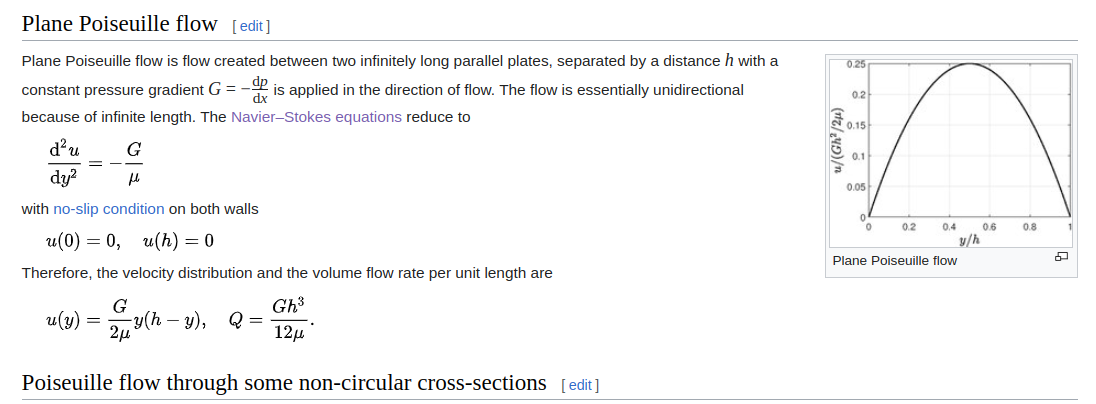

In [ ]:
h = R  # m, plate seperation
Q = 1  # m/s, specify volumetric flowrate
G = (Q * 12 * mu) / (h**3)
#G = dP/ L

def u(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

# BC:
def u_bc(x):
    y = x[1]
    if y == 0:
        return 0.0
    elif y == h:
        return 0.0

TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

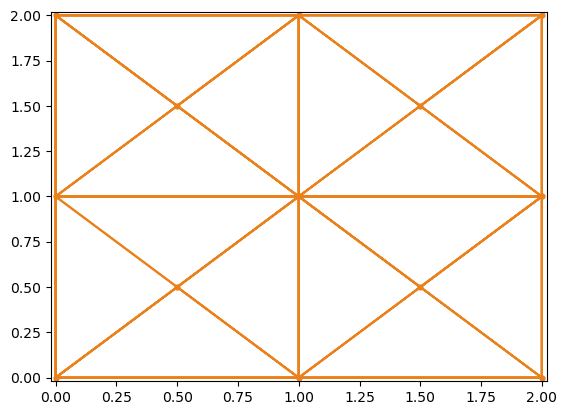

<Figure size 640x480 with 0 Axes>

In [2]:
# Solid boundaries of plate
x_lb = 0
x_ub = 2
y_lb = 0
y_ub = 2
domain = [(x_lb, x_ub), (y_lb, y_ub)]
HC = Complex(2, domain)
HC.triangulate()
for i in range(1):
    HC.refine_all()
    
HC.plot_complex()

In [ ]:
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='orange')
for v in HC.V:
    for vd in v.vd:
        x = [v.x[0], vd.x[0]]
        y = [v.x[1], vd.x[1]]
        plt.plot(x, y, color='orange')
plt.show()

In [3]:
points = []
for v in HC.V:
    points.append(v.x_a)
points = np.array(points)
points

array([[0. , 0. ],
       [2. , 2. ],
       [2. , 0. ],
       [0. , 2. ],
       [1. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [2. , 1. ],
       [1. , 2. ],
       [1.5, 0.5],
       [0.5, 1.5],
       [1.5, 1.5],
       [0.5, 0.5]], dtype=float128)

In [4]:
#points =points + 0.5*(np.random.rand(points.shape[0], 2) - 0.5)#, points.shape[0]

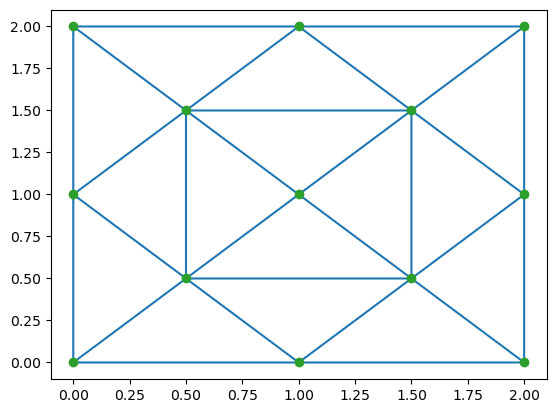

In [6]:
import numpy as np
#points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
from scipy.spatial import Delaunay
tri = Delaunay(points)

import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [7]:
domain = [(x_lb, x_ub), (y_lb, y_ub)]
HC = Complex(2, domain)
for s in tri.simplices:
    for v1i in s:
        for v2i in s:
            if v1i is v2i:
                continue
            else:
                v1 = tuple(points[v1i])
                v2 = tuple(points[v2i])
                HC.V[v1].connect(HC.V[v2])
                
HC.V.print_out()                

Vertex cache of size: 13:
Vertex: (2.0, 1.0)
Connections: (1.5, 0.5) (1.5, 1.5) (2.0, 0.0) (2.0, 2.0) 
Vertex: (1.5, 0.5)
Connections: (0.5, 0.5) (1.5, 1.5) (2.0, 1.0) (1.0, 1.0) (2.0, 0.0) (1.0, 0.0) 
Vertex: (2.0, 0.0)
Connections: (1.0, 0.0) (1.5, 0.5) (2.0, 1.0) 
Vertex: (1.0, 0.0)
Connections: (0.5, 0.5) (1.5, 0.5) (2.0, 0.0) (0.0, 0.0) 
Vertex: (1.5, 1.5)
Connections: (1.0, 2.0) (2.0, 1.0) (1.0, 1.0) (1.5, 0.5) (2.0, 2.0) (0.5, 1.5) 
Vertex: (2.0, 2.0)
Connections: (1.0, 2.0) (1.5, 1.5) (2.0, 1.0) 
Vertex: (1.0, 2.0)
Connections: (0.0, 2.0) (0.5, 1.5) (1.5, 1.5) (2.0, 2.0) 
Vertex: (0.5, 0.5)
Connections: (0.0, 1.0) (0.0, 0.0) (1.0, 1.0) (1.5, 0.5) (1.0, 0.0) (0.5, 1.5) 
Vertex: (0.0, 0.0)
Connections: (1.0, 0.0) (0.5, 0.5) (0.0, 1.0) 
Vertex: (0.0, 1.0)
Connections: (0.5, 0.5) (0.5, 1.5) (0.0, 2.0) (0.0, 0.0) 
Vertex: (0.5, 1.5)
Connections: (0.0, 1.0) (0.5, 0.5) (1.0, 2.0) (1.5, 1.5) (1.0, 1.0) (0.0, 2.0) 
Vertex: (0.0, 2.0)
Connections: (0.0, 1.0) (0.5, 1.5) (1.0, 2.0) 
Vertex

In [ ]:
HC.vertex_face_mesh(field_conversions=True)
#  self.vertices_fm = []  # Vertices (A list of ob
#  self.simplices_fm = []  # Faces
HC.vertices_fm, HC.simplices_fm_i

In [9]:
# Rest complex to Delaunay result and then compute the dual

domain = [(x_lb, x_ub), (y_lb, y_ub)]
HC = Complex(2, domain)
for s in tri.simplices:
    for v1i in s:
        for v2i in s:
            if v1i is v2i:
                continue
            else:
                v1 = tuple(points[v1i])
                v2 = tuple(points[v2i])
                HC.V[v1].connect(HC.V[v2])
                
HC = compute_vd(HC)            
#HC.plot_complex()

In [10]:
dual_points = []
for vd in HC.Vd:
    #print('-')
    #print(vd.x_a)
    dual_points.append(vd.x_a)
    #for vdn in vd.v
dual_points = np.array(dual_points)

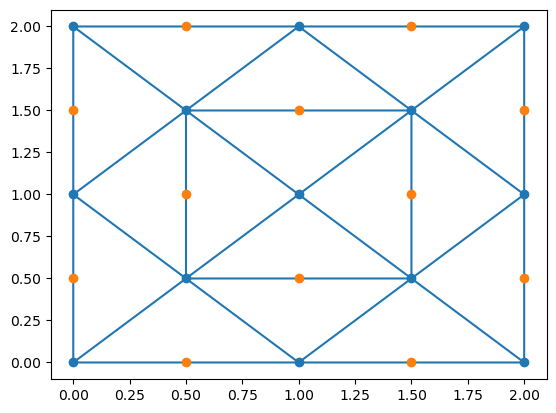

In [15]:
import matplotlib.pyplot as plt
for v in HC.V:
    for vd in v.vd:
        x = [v.x[0], vd.x[0]]
        y = [v.x[1], vd.x[1]]
        #plt.plot(x, y, '--', color='tab:green')
plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

plt.show()

In [12]:
for vd in HC.Vd:
    print(vd.x)

(2.0, 0.5)
(1.5, 1.0)
(2.0, 1.5)
(1.0, 0.4999999999999999)
(1.5, 1.1102230246251563e-16)
(0.5, 1.1102230246251563e-16)
(1.0, 1.5)
(1.5, 2.0)
(0.5, 2.0)
(0.4999999999999999, 1.0)
(1.1102230246251563e-16, 0.5)
(1.1102230246251563e-16, 1.5)


# Next we find the dual edges



In [13]:
for v1 in HC.V:
    for v2 in v1.nn:
        v1vdv2vd = v1.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
        print(len(v1vdv2vd))
        for v in v1vdv2vd:
            print(v.x)
        #print(v.vd.intersection(v2.vd))

2
(2.0, 0.5)
(1.5, 1.0)
2
(1.5, 1.0)
(2.0, 1.5)
1
(2.0, 0.5)
1
(2.0, 1.5)
1
(1.0, 0.4999999999999999)
1
(1.5, 1.0)
2
(2.0, 0.5)
(1.5, 1.0)
2
(1.5, 1.0)
(1.0, 0.4999999999999999)
2
(1.5, 1.1102230246251563e-16)
(2.0, 0.5)
2
(1.5, 1.1102230246251563e-16)
(1.0, 0.4999999999999999)
1
(1.5, 1.1102230246251563e-16)
2
(1.5, 1.1102230246251563e-16)
(2.0, 0.5)
1
(2.0, 0.5)
2
(0.5, 1.1102230246251563e-16)
(1.0, 0.4999999999999999)
2
(1.5, 1.1102230246251563e-16)
(1.0, 0.4999999999999999)
1
(1.5, 1.1102230246251563e-16)
1
(0.5, 1.1102230246251563e-16)
2
(1.0, 1.5)
(1.5, 2.0)
2
(1.5, 1.0)
(2.0, 1.5)
2
(1.0, 1.5)
(1.5, 1.0)
1
(1.5, 1.0)
2
(2.0, 1.5)
(1.5, 2.0)
1
(1.0, 1.5)
1
(1.5, 2.0)
2
(2.0, 1.5)
(1.5, 2.0)
1
(2.0, 1.5)
1
(0.5, 2.0)
2
(1.0, 1.5)
(0.5, 2.0)
2
(1.0, 1.5)
(1.5, 2.0)
1
(1.5, 2.0)
2
(1.1102230246251563e-16, 0.5)
(0.4999999999999999, 1.0)
2
(0.5, 1.1102230246251563e-16)
(1.1102230246251563e-16, 0.5)
2
(1.0, 0.4999999999999999)
(0.4999999999999999, 1.0)
1
(1.0, 0.4999999999999999)
2
(0.

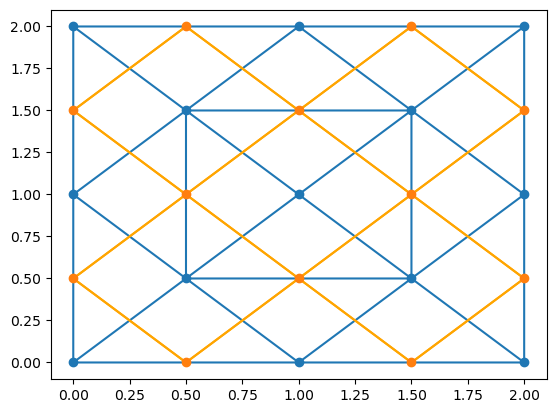

In [16]:
import matplotlib.pyplot as plt
for v in HC.V:
    # "Connect duals":
    for v2 in v.nn:
        v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
        if len(v1vdv2vd) == 1:
            continue
        v1vdv2vd = list(v1vdv2vd)
        x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
        y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
        plt.plot(x, y, color='orange')
        
    for vd in v.vd:
        x = [v.x[0], vd.x[0]]
        y = [v.x[1], vd.x[1]]
        #plt.plot(x, y, '--', color='tab:green')
plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

plt.show()

# Area-volume computations

(Needed for the initial and boundary conditions?)

In [58]:
# For each vertex compute its local dual area:
import numpy as np

def d_area(vp1):
    """
    Compute the dual area of a vertex object vp1, which is the sum of the areas
    of the local dual triangles formed between vp1, its neighbouring vertices, 
    and their shared dual vertices.

    Parameters:
    -----------
    vp1 : object
        A vertex object containing the following attributes:
        - vp1.nn: a list of neighboring vertex objects
        - vp1.vd: a set of dual vertex objects
        - vp1.x_a: a numpy array representing the position of vp1

    Returns:
    --------
    darea : float
        The total dual area of the vertex object vp1
    """

    darea = 0  # Initialize total dual area to zero
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        h = np.linalg.norm(mp - vp1.x_a)
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)
            # Add the area of the dual triangle to the total dual area
            darea += 0.5 * b * h

    return darea


Areas = []
for vp1 in HC.V:
    area = 0 
    area += d_area(vp1)
        
    Areas.append(area)
        
        

In [59]:
np.sum(Areas)  # Validated this for 1x1 and 2x2 grids

4.000000000000000111

In [22]:
np.linalg.norm([2, 3])

3.605551275463989

# Velocity Fields

In [25]:
# Assign velocity field to all points:
for v in HC.V:
    v.u = np.array([u(v.x_a), 0])

In [27]:
points= []
for vd in HC.Vd:
    print('-')
    print(f'vd.x = {vd.x}')
    points.append(vd.x)
    for vn in vd.nn:
        print(f'vn.x = {vn.x}')
points = np.array(vd.x)
#plt.figure()
plt.scatter(points)

-
vd.x = (0.5, 1.1102230246251563e-16)
vn.x = (1, 0)
vn.x = (0.5, 0.5)
vn.x = (0, 0)
-
vd.x = (1.1102230246251563e-16, 0.5)
vn.x = (0, 1)
vn.x = (0.5, 0.5)
vn.x = (0, 0)
-
vd.x = (0.9999999999999998, 0.5)
vn.x = (1, 0)
vn.x = (0.5, 0.5)
vn.x = (1, 1)
-
vd.x = (0.5, 0.9999999999999998)
vn.x = (0, 1)
vn.x = (0.5, 0.5)
vn.x = (1, 1)


TypeError: scatter() missing 1 required positional argument: 'y'

# Time integrator

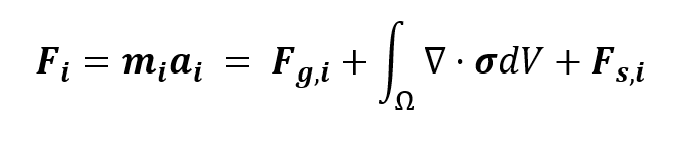

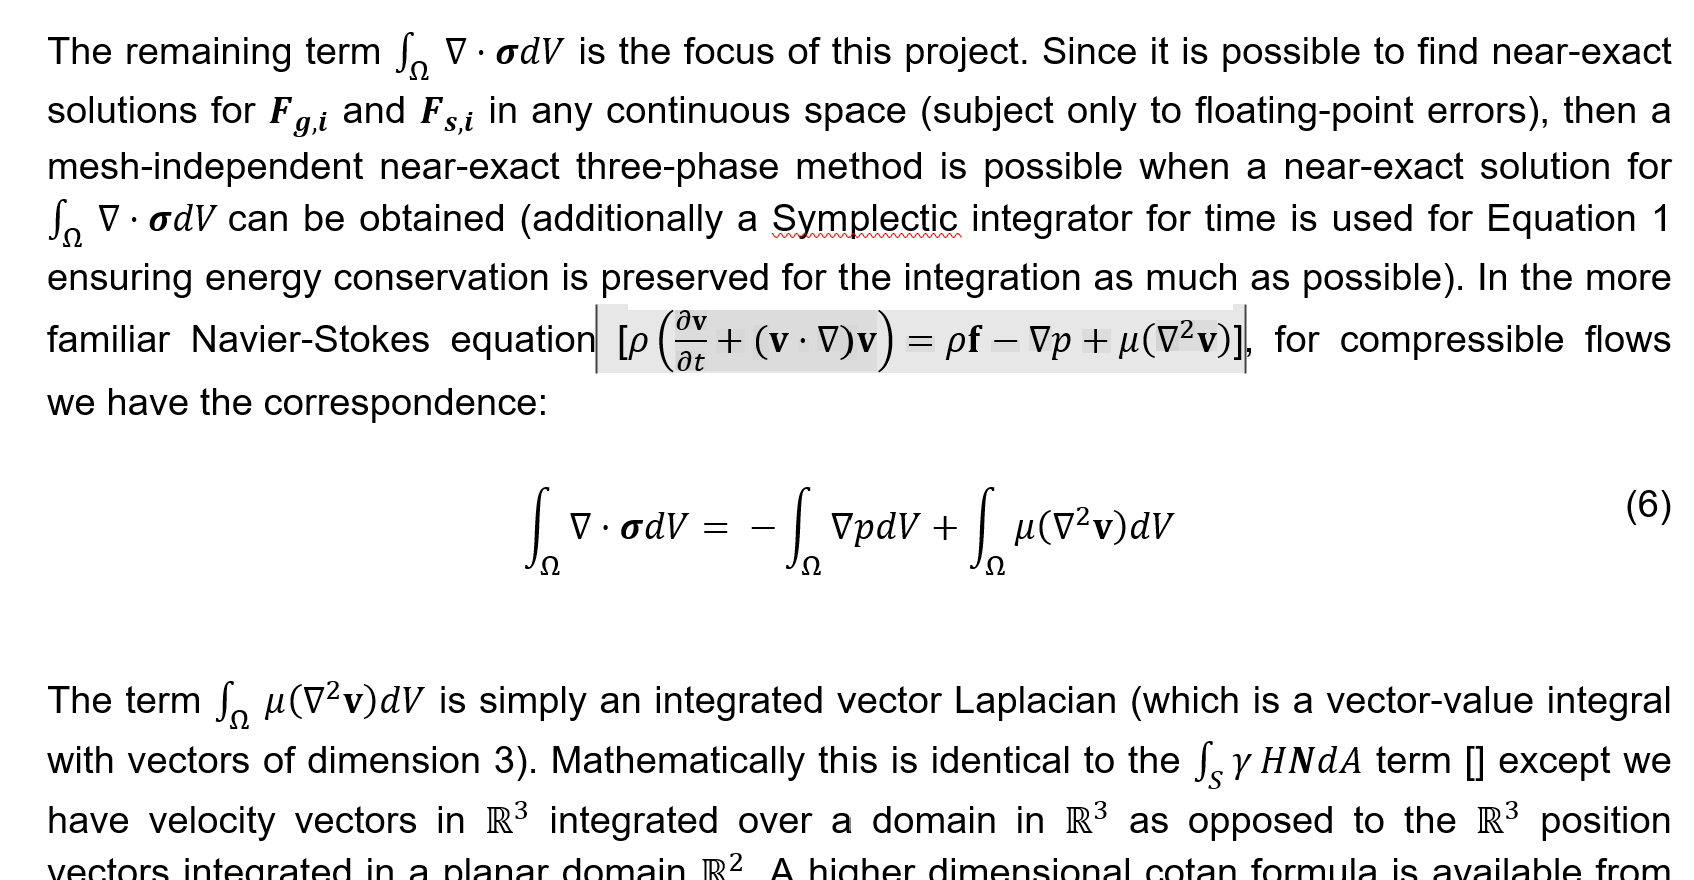



In [ ]:

from scipy.fftpack import fft2, ifft2

def laplacian(Z, dx):
    Z_left = np.roll(Z, shift=-1, axis=1)
    Z_right = np.roll(Z, shift=1, axis=1)
    Z_up = np.roll(Z, shift=-1, axis=0)
    Z_down = np.roll(Z, shift=1, axis=0)
    return (Z_left + Z_right + Z_up + Z_down - 4 * Z) / dx**2

def simulate_flow(N, dt, T_end, nu, forcing):
    dx = 1 / N
    X, Y = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))
    
    omega = np.zeros((N, N))
    psi = np.zeros((N, N))
    
    T = 0
    while T < T_end:
        omega_hat = fft2(omega)
        kx, ky = np.meshgrid(np.arange(N), np.arange(N))
        laplacian_k = 2 * (np.cos(2 * np.pi * kx / N) + np.cos(2 * np.pi * ky / N) - 2)
        laplacian_k[0, 0] = 1  # Avoid division by zero
        psi_hat = -omega_hat / laplacian_k
        psi = np.real(ifft2(psi_hat))
        
        u = np.roll(psi, shift=1, axis=0) - np.roll(psi, shift=-1, axis=0)
        v = -np.roll(psi, shift=1, axis=1) + np.roll(psi, shift=-1, axis=1)
        
        omega_t = -u * laplacian(omega, dx) - v * laplacian(omega.T, dx).T + nu * laplacian(omega, dx) + forcing(X, Y, T)
        omega += dt * omega_t
        T += dt
        
    return X, Y, psi

def forcing(X, Y, T):
    F = 10 * np.sin(np.pi * X) * np.sin(np.pi * Y) * np.exp(-T / 8)
    return F

N = 128
dt = 0.001
T_end = 10
nu = 0.01

if 0:
    X, Y, psi = simulate_flow(N, dt, T_end, nu, forcing)
    u = np.roll(psi, shift=1, axis=0) - np.roll(psi, shift=-1, axis=0)
    v = -np.roll(psi, shift=1, axis=1) + np.roll(psi, shift=-1, axis=1)

    plt.figure(figsize=(8, 8))
    plt.streamplot(X, Y, u, v, density=2)
    plt.show()


In [ ]:
domain = p[]

The exact solution is derived by assuming $u=\left(u_x(x, y, z), 0,0\right)$, with the $x$ axis pointing along the channel. Since $\nabla \cdot u=0$, $u$ cannot depend on $x$. The physics of channel flow is also two-dimensional so we can omit the $z$ coordinate (more precisely: $\partial / \partial z=0$ ). Inserting $u=\left(u_x, 0,0\right)$ in the (scaled) governing equations gives $u_x^{\prime \prime}(y)=\partial p / \partial x$. Differentiating this equation with respect to $x$ shows that $\partial^2 p / \partial^2 x=0$ so $\partial p / \partial x$ is a constant, here called $-\beta$. This is the driving force of the flow and can be specified as a known parameter in the problem. Integrating $u_x^{\prime \prime}(y)=-\beta$ over the width of the channel, $[0,1]$, and requiring $u=(0,0,0)$ at the channel walls, results in $u_x=\frac{1}{2} \beta y(1-y)$. The characteristic inlet velocity $U$ can be taken as the maximum inflow at $y=1 / 2$, implying $\beta=8$. The length of the channel, $L / H$ in the scaled model, has no impact on the result, so for simplicity we just compute on the unit square. Mathematically, the pressure must be prescribed at a point, but since $p$ does not depend on $y$, we can set $p$ to a known value, e.g. zero, along the outlet boundary $x=1$. The result is $p(x)=8(1-x)$ and $u_x=4 y(1-y)$.

The boundary conditions can be set as $p=8$ at $x=0, p=0$ at $x=1$ and $u=(0,0,0)$ on the walls $y=0,1$. This defines the pressure drop and should result in unit maximum velocity at the inlet and outlet and a parabolic velocity profile without further specifications. Note that it is only meaningful to solve the Navier-Stokes equations in 2D or 3D geometries, although the underlying mathematical problem collapses to two 1D problems, one for $u_x(y)$ and one for $p(x)$.

In [90]:
#Analytical
U_char = 0.  # at y= 1/2
def u_x_analytical(y):
    return 4 * y * (1 - y)

In [ ]:
# Define an initial velocity field using the initial condition 


In [ ]:

import matplotlib.pyplot as plt

def startup_poiseuille_flow(N, num_steps, R, L, nu, dt):
    dr = R / N
    r = np.linspace(dr / 2, R - dr / 2, N)
    v_z = np.zeros(N)
    
    A = np.zeros((N, N))
    for i in range(N):
        A[i, i] = 1 + 2 * nu * dt / dr**2
        if i > 0:
            A[i, i - 1] = -nu * dt / dr**2 - nu * dt / (2 * r[i] * dr)
        if i < N - 1:
            A[i, i + 1] = -nu * dt / dr**2 + nu * dt / (2 * r[i] * dr)

    for _ in range(num_steps):
        v_z = np.linalg.solve(A, v_z)
        
    return r, v_z

N = 100
num_steps = 1000
R = 0.05
L = 1
nu = 0.01
dt = 0.001

r, v_z = startup_poiseuille_flow(N, num_steps, R, L, nu, dt)

plt.figure()
plt.plot(r, v_z)
plt.xlabel('Radial position (m)')
plt.ylabel('Axial velocity (m/s)')
plt.title('Startup of Poiseuille Flow in a Pipe')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def taylor_green_vortex(X, Y, t, nu):
    u = np.sin(X) * np.cos(Y) * np.exp(-2 * nu * t)
    v = -np.cos(X) * np.sin(Y) * np.exp(-2 * nu * t)
    return u, v

N = 128
nu = 0.01
t = 0.0

X, Y = np.meshgrid(np.linspace(0, 2 * np.pi, N, endpoint=False), np.linspace(0, 2 * np.pi, N, endpoint=False))
u, v = taylor_green_vortex(X, Y, t, nu)

# Downsample the velocity field to make the vector plot more readable
downsample = 8
X_ds, Y_ds = np.meshgrid(np.linspace(0, 2 * np.pi, N // downsample, endpoint=False), np.linspace(0, 2 * np.pi, N // downsample, endpoint=False))
u_ds = u[::downsample, ::downsample]
v_ds = v[::downsample, ::downsample]

plt.figure(figsize=(8, 8))
plt.quiver(X_ds, Y_ds, u_ds, v_ds)
plt.title('Taylor-Green Vortex Velocity Field')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
